In [ ]:
from google.colab import drive
drive.mount("/content/m_drive")
from pathlib import Path
import pandas as pd

Drive already mounted at /content/m_drive; to attempt to forcibly remount, call drive.mount("/content/m_drive", force_remount=True).


In [ ]:
import os
import re
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import ast

In [ ]:
import json, math, numpy as np, pandas as pd, zipfile, random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


N_SAMPLES = 2000
VOCAB_SIZE = 80
EPOCHS = 5
BATCH = 64
SEED = 2025
LEARNING_RATE = 5e-4

In [ ]:
DATA_PATH = Path('/content/m_drive/MyDrive/Colab Notebooks/train_standardized.csv')  # your uploaded CSV
df = pd.read_csv(DATA_PATH, sep=',')
#display(df.info())

In [ ]:
json_file_path = '/content/m_drive/MyDrive/Colab Notebooks/unified_skills_mappings.json' # Укажите правильный путь
try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        skills_data = json.load(f)
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути '{json_file_path}'")
    # В случае ошибки создадим пустой словарь, чтобы код не падал
    skills_data = {}

SKILL_MAP_FROM_JSON = {}

for original_skill, details in skills_data.items():
    key = original_skill.lower()

    value = details.get('unified_skill', original_skill).lower()

    SKILL_MAP_FROM_JSON[key] = value

print(f"Загружено {len(SKILL_MAP_FROM_JSON)}")
for i, (k, v) in enumerate(SKILL_MAP_FROM_JSON.items()):
    if i >= 5: break
    print(f"'{k}'  ->  '{v}'")


Загружено и обработано 2487 правил из JSON.
'1c document management'  ->  'работа с системами управления документами 1с'
'1c erp'  ->  'владение системой 1с:erp'
'1c software proficiency'  ->  'владение программным обеспечением 1с'
'1c упп'  ->  'работа с программным обеспечением 1с: управление производственным предприятием'
'1c: accounting'  ->  'владение программным обеспечением 1с: бухгалтерия'


In [ ]:
MANUAL_SKILL_MAP = {
    # Ключ (что ищем) -> Значение (на что меняем)

    # --- Группа "Налоговый учет" ---
    'знание налогового учета': 'налоговый учет',
    'ведение налогового учета': 'налоговый учет',

    # --- Группа "ПК" ---
    'владение компьютерная техника/оборудование': 'навыки работы с пк',
    'владение/пользователь пк': 'навыки работы с пк',
    'знание компьютерных и прочих программ': 'навыки работы с пк',
    'навыки работы с персональным компьютером': 'навыки работы с пк',

    # --- Группа "Зарплата" ---
    'расчет и начисление заработной платы': 'расчет заработной платы',

    # --- Группа "Первичка" ---
    'ведение первичной документации': 'работа с первичной документацией',
    'обработка первичной документации': 'работа с первичной документацией',
    'первичная бухгалтерия': 'работа с первичной документацией',

    # --- Группа "Бух. учет" ---
    'знание бухгалтерского учета': 'бухгалтерский учет',
    'ведение бухгалтерского учета': 'бухгалтерский учет',
    'организация бухгалтерского учета': 'бухгалтерский учет',
    'опыт работы бухгалтером': 'бухгалтерский учет', # Можно и так обобщить

    # --- Группа "ТМЦ" ---
    'анализ тмц': 'учет тмц',
    'движение/перемещение тмц': 'учет тмц',
    'инвентаризация тмц': 'учет тмц',
    'комплектация тмц': 'учет тмц',

    # --- Группа "НМА" ---
    'амортизация нма': 'учет нма',
    'инвентаризация нма': 'учет нма',

    # --- Группа "Затраты" ---
    'анализ затрат': 'управление затратами',
    'оптимизация затрат': 'управление затратами',
    'нормирование затрат': 'управление затратами',
    'планирование затрат': 'управление затратами',

    # --- Упрощение неопределенных сокращений ---
    'зна': 'знания', # Или можно просто удалить, если это мусор
    'компь': 'навыки работы с пк',
    'бух': 'бухгалтерия',

}

In [ ]:
def normalize_skill(text: str) -> str:
    s = str(text).lower().strip()


    s = re.sub(r'1[сc]', '1c', s)  # только для 1c

    s = re.sub(r'\s+', ' ', s)
    s = s.strip(' "\'«».,;:|')

    if s in SKILL_MAP_FROM_JSON:
        s = SKILL_MAP_FROM_JSON[s]
    elif s in MANUAL_SKILL_MAP:
        s = MANUAL_SKILL_MAP[s]
    return s
def to_list_safe(x):
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s in ("", "[]", "{}", "nan", "None"):
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
        return [str(v)]
    except Exception:
        return re.split(r'[;\n\r|]+', s)


def explode_item(item: str):
    text = str(item)

    text = re.sub(r'на основе\s*esco\s*taxonomy:.*', '', text, flags=re.IGNORECASE)

    text = re.sub(r'\s+[—\-–]\s+', ' | ', text)

    text = re.sub(r'\s+\d{1,2}[.)]\s+', ' | ', text)
    text = re.sub(r'^\s*\d{1,2}[.)]\s+', '', text)

    text = re.sub(r'[;\n\r]+', ' | ', text)

    text = re.sub(r'\s*\|\s*', ' | ', text)
    parts = [p.strip() for p in text.split(' | ') if p.strip()]
    return parts


def clean_and_parse_skills(row):
    skill_source_columns = [
        'skills_vacancy', 'hardSkills_vacancy', 'softSkills_vacancy',
        'standardize_skills_cv', 'combined_skills'
    ]
    raw_items = []
    for col in skill_source_columns:
        if col not in row.index:
            continue
        vals = row[col]
        seq = vals if isinstance(vals, list) else to_list_safe(vals)
        for it in seq:
            raw_items.extend(explode_item(it))

    skills = []
    for t in raw_items:
        t = normalize_skill(t)
        if not t:
            continue
        if len(t) < 2 or re.fullmatch(r'\d+', t):
            continue
        skills.append(t)

    return sorted(set(skills))

In [ ]:
df["salary_mid"] = df[["salaryMin_vacancy", "salaryMax_vacancy"]].mean(axis=1, skipna=True)
df = df[df["salary_mid"].notna() & (df["salary_mid"] > 0)].copy()

df['skills_list_clean'] = df.apply(clean_and_parse_skills, axis=1)
print("\nТип первого элемента в skills_list_clean:", type(df['skills_list_clean'].iloc[0]))
display(df[['standardize_skills_cv', 'skills_list_clean']].head())



Тип первого элемента в skills_list_clean: <class 'list'>


,standardize_skills_cv,skills_list_clean
0,"['работа в команде', 'социальный интеллект']","[работа в команде, социальный интеллект]"
1,"['ведение документации', 'ведение кадровой док...","[ведение документации, ведение кадровой докуме..."
2,"['добросовестность', 'ответственность за выпол...","[обслуживание и ремонт электрооборудования, ор..."
3,['1. Соблюдение техники безопасности\n2. Соблю...,"[испытание электрооборудования, монтаж кабельн..."
4,[],[]


In [ ]:

df['region'] = df['localityName'].fillna('Не указан')
print(f"Количество уникальных регионов: {df['region'].nunique()}")

df['date_published'] = pd.to_datetime(df['datePublished'], errors='coerce')
df['year_published'] = df['date_published'].dt.year
df['month_published'] = df['date_published'].dt.month
df['day_of_week_published'] = df['date_published'].dt.dayofweek

df['isQuoted'] = df['isQuoted'].fillna(False).astype(int)
df['isMobilityProgram'] = df['isMobilityProgram'].fillna(False).astype(int)

df['scheduleType_vacancy'] = df['scheduleType_vacancy'].astype('category').cat.codes
df['companyBusinessSize'] = df['companyBusinessSize'].astype('category').cat.codes
df['needMedcard'] = df['needMedcard'].astype('category').cat.codes

Количество уникальных регионов: 4785


/tmp/ipython-input-199787840.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isMobilityProgram'] = df['isMobilityProgram'].fillna(False).astype(int)


In [ ]:
df[["salaryMin_vacancy", "salaryMax_vacancy"]]

,salaryMin_vacancy,salaryMax_vacancy
0,40000.0,50000.0
1,36122.0,45000.0
2,48000.0,48000.0
3,42332.0,42332.0
4,35000.0,65000.0
...,...,...
150488,52000.0,52000.0
150489,29172.0,0.0
150490,38000.0,38000.0
150491,40000.0,40000.0


In [ ]:
vacancy_columns = [
    'vacancyName', 'experienceRequirements', 'scheduleType_vacancy', 'needMedcard',
    'requiredDriveLicense', 'isQuoted', 'isMobilityProgram',
    'qualifications', 'responsibilities', 'year_published',
    'month_published', 'day_of_week_published', "salaryMin_vacancy", "salaryMax_vacancy", 'salary_mid', 'experience', 'education',
    'positionName', 'companyBusinessSize', 'professionalSphereName', 'age', 'region'
]

existing_core_cols = [col for col in vacancy_columns if col in df.columns]
X = df[existing_core_cols].copy()


print("Обработка и нормализация навыков...")
X['skills_list_clean'] = df.apply(clean_and_parse_skills, axis=1)
print("Готово.")



Обработка и нормализация навыков...
Готово.


In [ ]:
display(X.head(3))
print(X.shape)

,vacancyName,experienceRequirements,scheduleType_vacancy,needMedcard,requiredDriveLicense,isQuoted,isMobilityProgram,qualifications,responsibilities,year_published,...,salaryMax_vacancy,salary_mid,experience,education,positionName,companyBusinessSize,professionalSphereName,age,region,skills_list_clean
0,Электромонтер по ремонту и обслуживанию электр...,0.0,5,1,[],0,0,Наличие опыта работы (желательно).,Качественно и своевременно выполнять возложенн...,2025.0,...,50000.0,45000.0,2,Среднее,Музыкальный-руководитель,4,Производство,27.0,"Томская-область,-Колпашевский-район,-г-Колпашево","[работа в команде, социальный интеллект]"
1,Специалист по кадрам,1.0,3,0,[],0,0,среднее или высшее профессиональное образовани...,"Подготовка кадровых документов (приемы, перево...",2025.0,...,45000.0,40561.0,14,Высшее-бакалавриат,Специалист-по-кадровому-делопроизводству,4,"Кадровая служба, управление персоналом",38.0,"Пермский-край,-г-Пермь","[ведение документации, ведение кадровой докуме..."
2,Электромонтер по ремонту и обслуживанию электр...,1.0,3,1,[],0,0,1. Опыт работы на промышленных предприятиях по...,"1. Обслуживание токарно-винторезных станков, л...",2025.0,...,48000.0,48000.0,9,Высшее-бакалавриат,Администратор,0,Производство,33.0,"Омская-область,-г-Омск","[обслуживание и ремонт электрооборудования, ор..."


(148772, 23)


In [ ]:
X['experience'] = X['experience'] * 12
X.rename(columns={
    'salaryMin_vacancy': 'salary_lower',
    'salaryMax_vacancy': 'salary_upper',
    'experience': 'experience_months',
    'skills_list_clean': 'skills'
}, inplace=True)

In [ ]:
X["salary_mid"].head(2)

,salary_mid
0,45000.0
1,40561.0


In [ ]:
def map_education_level(edu_str):
    edu_str = str(edu_str).lower()
    if 'высшее' in edu_str: return 'High'
    if 'среднее специальное' in edu_str or 'профессиональное' in edu_str: return 'College'
    if 'среднее' in edu_str: return 'School'
    return 'Other'

X['education_level'] = X['education'].apply(map_education_level)

In [ ]:
def map_seniority(pos_name):
    s = str(pos_name).lower()
    if any(k in s for k in ['главный', 'ведущий', 'руководитель', 'директор', 'старший', 'senior', 'lead']): return "Senior"
    if any(k in s for k in ['младший', 'стажер', 'junior', 'ассистент']): return "Junior"
    return "Mid"
X['seniority'] = X['positionName'].apply(map_seniority)
display(X['seniority'].value_counts())

,count
seniority,
Mid,133435
Senior,14625
Junior,712


In [ ]:
X.rename(columns={'companyBusinessSize': 'company_size'}, inplace=True)
X.rename(columns={'professionalSphereName': 'industry'}, inplace=True)

In [ ]:
print(f"Размер DF до фильтрации: {len(X)}")
salary_cols = ['salary_lower', 'salary_mid', 'salary_upper']

Размер DF до фильтрации: 148772


In [ ]:
X.dropna(subset=salary_cols + ['age'], inplace=True)
print(f"После удаления строк без ЗП и возраста: {len(X)}")

После удаления строк без ЗП и возраста: 148617


In [ ]:
df_prepared = X[X['skills'].apply(len) > 0]
print(f"После удаления строк без навыков: {len(df_prepared)}")
df_prepared = df_prepared[df_prepared['salary_lower'] <= df_prepared['salary_upper']]
print(f"После проверки корректности вилки ЗП: {len(df_prepared)}")
for col in salary_cols:
    df_prepared[col] = np.log1p(df_prepared[col])

print("\nЗарплаты были логарифмированы. Пример:")
display(df_prepared[salary_cols].head())

После удаления строк без навыков: 89451
После проверки корректности вилки ЗП: 77040

Зарплаты были логарифмированы. Пример:


,salary_lower,salary_mid,salary_upper
0,10.596660,10.714440,10.819798
1,10.494685,10.610587,10.714440
2,10.778977,10.778977,10.778977
3,10.653322,10.653322,10.653322
8,10.239996,10.357775,10.463132


In [ ]:
df_prepared['industry'] = df_prepared['industry'].fillna('Не указана').astype(str)

In [ ]:
df_prepared['industry'].isna().sum()

np.int64(0)

In [ ]:
all_skills = sorted(list(set(skill for sublist in df_prepared['skills'] for skill in sublist)))
all_regions = sorted(df_prepared['region'].unique().tolist())
all_industries = sorted(df_prepared['industry'].unique().tolist())
all_sizes = sorted(df_prepared['company_size'].unique().tolist())
all_education = sorted(df_prepared['education_level'].unique().tolist())
all_seniority = sorted(df_prepared['seniority'].unique().tolist())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
all_industries

['Административная работа, секретариат, АХО',
 'Банки, кредит, страхование, пенсионное обеспечение',
 'Безопасность, службы охраны',
 'Бухгалтерия, налоги, управленческий учет',
 'Высший менеджмент',
 'Государственная служба, некоммерческие организации',
 'Добывающая промышленность',
 'Домашний персонал',
 'ЖКХ, эксплуатация',
 'Здравоохранение и социальное обеспечение',
 'Информационные технологии, телекоммуникации, связь',
 'Искусство, культура и развлечения',
 'Кадровая служба, управление персоналом',
 'Консалтинг, стратегическое развитие, управление',
 'Легкая промышленность',
 'Лесная, деревообрабатывающая, целлюлозно-бумажная промышленность',
 'Маркетинг, реклама, PR',
 'Машиностроение',
 'Металлургия, металлообработка',
 'Не указана',
 'Образование, наука',
 'Пищевая промышленность',
 'Продажи, закупки, снабжение, торговля',
 'Производство',
 'Работы, не требующие квалификации',
 'Рабочие специальности',
 'Развлечения, Мода, Шоу-бизнес',
 'Сельское хозяйство, экология, ветеринар

In [ ]:
VOCAB_SIZE = len(all_skills); pad_idx = VOCAB_SIZE

skill2idx = {s: i for i, s in enumerate(all_skills)}
region2idx = {r: i for i, r in enumerate(all_regions)}; region2idx['<UNK>'] = len(region2idx)
industry2idx = {r: i for i, r in enumerate(all_industries)}; industry2idx['<UNK>'] = len(industry2idx)
size2idx = {s: i for i, s in enumerate(all_sizes)}; size2idx['<UNK>'] = len(size2idx)
education2idx = {e: i for i, e in enumerate(all_education)}; education2idx['<UNK>'] = len(education2idx)
seniority2idx = {e: i for i, e in enumerate(all_seniority)}; seniority2idx['<UNK>'] = len(seniority2idx)

In [ ]:
industry2idx

{'Административная работа, секретариат, АХО': 0,
 'Банки, кредит, страхование, пенсионное обеспечение': 1,
 'Безопасность, службы охраны': 2,
 'Бухгалтерия, налоги, управленческий учет': 3,
 'Высший менеджмент': 4,
 'Государственная служба, некоммерческие организации': 5,
 'Добывающая промышленность': 6,
 'Домашний персонал': 7,
 'ЖКХ, эксплуатация': 8,
 'Здравоохранение и социальное обеспечение': 9,
 'Информационные технологии, телекоммуникации, связь': 10,
 'Искусство, культура и развлечения': 11,
 'Кадровая служба, управление персоналом': 12,
 'Консалтинг, стратегическое развитие, управление': 13,
 'Легкая промышленность': 14,
 'Лесная, деревообрабатывающая, целлюлозно-бумажная промышленность': 15,
 'Маркетинг, реклама, PR': 16,
 'Машиностроение': 17,
 'Металлургия, металлообработка': 18,
 'Не указана': 19,
 'Образование, наука': 20,
 'Пищевая промышленность': 21,
 'Продажи, закупки, снабжение, торговля': 22,
 'Производство': 23,
 'Работы, не требующие квалификации': 24,
 'Рабочие с

In [ ]:
train_df, test_df = train_test_split(df_prepared, test_size=0.2, random_state=SEED)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=SEED)

numeric_cols = ['age', 'experience_months']
scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
print("\nЧисловые признаки нормализованы.")


Числовые признаки нормализованы.


In [ ]:
class AdvancedSkillSetDataset(Dataset):
    def __init__(self, frame): self.frame = frame.reset_index(drop=True)
    def __len__(self): return len(self.frame)
    def __getitem__(self, idx):
        r = self.frame.iloc[idx]
        skills = [skill2idx[s] for s in r["skills"] if s in skill2idx]
        perm = np.random.permutation(len(skills)).tolist()
        skills = [skills[i] for i in perm]

        ctx_cat = {
            "region": torch.tensor(region2idx.get(r["region"], region2idx['<UNK>']), dtype=torch.long),
            "industry": torch.tensor(industry2idx.get(r["industry"], industry2idx['<UNK>']), dtype=torch.long),
            "size": torch.tensor(size2idx.get(str(r["company_size"]), size2idx['<UNK>']), dtype=torch.long),
            "education": torch.tensor(education2idx.get(r["education_level"], education2idx['<UNK>']), dtype=torch.long),
            "seniority": torch.tensor(seniority2idx.get(r["seniority"], seniority2idx['<UNK>']), dtype=torch.long)
        }
        ctx_num = torch.tensor(r[numeric_cols].values.astype(np.float32), dtype=torch.float32)
        target_values = r[['salary_lower', 'salary_mid', 'salary_upper']].values
        target_values_float = target_values.astype(np.float32)

        target = torch.tensor(target_values_float, dtype=torch.float32)

        return torch.tensor(skills, dtype=torch.long), ctx_cat, ctx_num, target

In [ ]:
def advanced_collate(batch):
    skills, ctx_cats, ctx_nums, targets = zip(*batch)
    max_len = max(len(s) for s in skills) if skills else 0
    if max_len == 0: max_len = 1
    skills_pad, mask = [], []
    for s in skills:
        s_len = len(s)
        pad = max_len - s_len
        s_pad = torch.cat([s, torch.full((pad,), pad_idx, dtype=torch.long)]) if pad > 0 else s
        skills_pad.append(s_pad.unsqueeze(0))
        m = torch.zeros(max_len, dtype=torch.bool); m[:s_len] = True
        mask.append(m.unsqueeze(0))
    final_ctx_cat = {k: torch.stack([d[k] for d in ctx_cats]) for k in ctx_cats[0].keys()}
    return (torch.cat(skills_pad), torch.cat(mask), final_ctx_cat,
            torch.stack(ctx_nums), torch.stack(targets))

In [ ]:
train_loader = DataLoader(AdvancedSkillSetDataset(train_df), batch_size=BATCH, shuffle=True, collate_fn=advanced_collate)
val_loader = DataLoader(AdvancedSkillSetDataset(val_df), batch_size=BATCH, shuffle=False, collate_fn=advanced_collate)
test_loader = DataLoader(AdvancedSkillSetDataset(test_df), batch_size=BATCH, shuffle=False, collate_fn=advanced_collate)

In [ ]:
class MCISUN_Advanced(nn.Module):
    def __init__(self, vocab_size, pad_idx, n_numeric, cat_dims, skill_emb=64, ctx_emb=24, hidden=128, heads=4):
        super().__init__()
        self.skill_emb = nn.Embedding(vocab_size + 1, skill_emb, padding_idx=pad_idx)
        self.cat_embs = nn.ModuleList([nn.Embedding(n, ctx_emb) for n in cat_dims.values()])

        total_ctx_dim = len(cat_dims) * ctx_emb + n_numeric
        self.lstm = nn.LSTM(skill_emb + total_ctx_dim, hidden, batch_first=True, bidirectional=True)
        self.attn = nn.MultiheadAttention(hidden * 2, heads, batch_first=True, dropout=0.1)
        self.head = nn.Sequential(nn.Linear(hidden * 2, hidden), nn.GELU(), nn.Linear(hidden, 3))

    def forward(self, skills, mask, ctx_cat, ctx_num):
        s = self.skill_emb(skills)
        c_cat = [emb(ctx_cat[key]) for emb, key in zip(self.cat_embs, ctx_cat.keys())]
        c = torch.cat(c_cat + [ctx_num], dim=1)
        B, T, _ = s.shape
        c_rep = c.unsqueeze(1).expand(B, T, c.size(1))
        x = torch.cat([s, c_rep], dim=2)
        h, _ = self.lstm(x)
        h2, _ = self.attn(h, h, h, key_padding_mask=~mask)
        contrib = self.head(h2)
        contrib = contrib * mask.unsqueeze(-1).float()
        return contrib.sum(dim=1), contrib

In [ ]:
class DeepSets_Advanced(nn.Module):
    def __init__(self, vocab_size, pad_idx, n_numeric, cat_dims, skill_emb=64, ctx_emb=24, hidden=128):
        super().__init__()
        self.skill_emb = nn.Embedding(vocab_size + 1, skill_emb, padding_idx=pad_idx)
        self.cat_embs = nn.ModuleList([nn.Embedding(n, ctx_emb) for n in cat_dims.values()])
        self.phi = nn.Sequential(nn.Linear(skill_emb, hidden), nn.GELU(), nn.Linear(hidden, hidden))

        total_ctx_dim = len(cat_dims) * ctx_emb + n_numeric
        self.rho = nn.Sequential(nn.Linear(hidden + total_ctx_dim, hidden), nn.GELU(), nn.Linear(hidden, 3))

    def forward(self, skills, mask, ctx_cat, ctx_num):
        s = self.skill_emb(skills)
        phi = self.phi(s)
        pooled = (phi * mask.unsqueeze(-1).float()).sum(dim=1)
        c_cat = [emb(ctx_cat[key]) for emb, key in zip(self.cat_embs, ctx_cat.keys())]
        c = torch.cat(c_cat + [ctx_num], dim=1)
        x = torch.cat([pooled, c], dim=1)
        return self.rho(x)

In [ ]:
def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    best, best_state = float("inf"), None
    for ep in range(1, epochs + 1):
        model.train(); tr = 0.0
        for skills, mask, ctx_cat, ctx_num, y in train_loader:
            skills, mask, y = skills.to(device), mask.to(device), y.to(device)
            ctx_cat = {k: v.to(device) for k, v in ctx_cat.items()}
            ctx_num = ctx_num.to(device)
            opt.zero_grad()
            yhat = model(skills, mask, ctx_cat, ctx_num)
            if isinstance(yhat, tuple): yhat = yhat[0]
            loss = F.mse_loss(yhat, y)
            loss.backward(); opt.step()
            tr += loss.item() * y.size(0)
        tr = math.sqrt(tr / len(train_loader.dataset))

        model.eval(); vl = 0.0
        with torch.no_grad():
            for skills, mask, ctx_cat, ctx_num, y in val_loader:
                skills, mask, y = skills.to(device), mask.to(device), y.to(device)
                ctx_cat = {k: v.to(device) for k, v in ctx_cat.items()}
                ctx_num = ctx_num.to(device)
                yhat = model(skills, mask, ctx_cat, ctx_num)
                if isinstance(yhat, tuple): yhat = yhat[0]
                vl += F.mse_loss(yhat, y).item() * y.size(0)
        vl = math.sqrt(vl / len(val_loader.dataset))
        print(f"[{model.__class__.__name__}] epoch {ep}: train RMSE={tr:.2f}  val RMSE={vl:.2f}")
        if vl < best:
            best, best_state = vl, {k: v.cpu().clone() for k, v in model.state_dict().items()}
    if best_state: model.load_state_dict(best_state)
    return model

In [ ]:
def evaluate(model):
    model.to(device); model.eval()
    ys, yh = [], []
    with torch.no_grad():
        for skills, mask, ctx_cat, ctx_num, y in test_loader:
            skills, mask, y = skills.to(device), mask.to(device), y.to(device)
            ctx_cat = {k: v.to(device) for k, v in ctx_cat.items()}
            ctx_num = ctx_num.to(device)
            yhat = model(skills, mask, ctx_cat, ctx_num)
            if isinstance(yhat, tuple): yhat = yhat[0]
            ys.append(y.cpu().numpy()); yh.append(yhat.cpu().numpy())
    y_true, y_pred = np.concatenate(ys), np.concatenate(yh)
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)

    mae = lambda x, y: float(np.mean(np.abs(x - y)))
    rmse = lambda x, y: float(np.sqrt(np.mean((x - y) ** 2)))
    return {
        "mid":   {"MAE": mae(y_true[:, 1], y_pred[:, 1]), "RMSE": rmse(y_true[:, 1], y_pred[:, 1])},
        "y_true": y_true, "y_pred": y_pred
    }

In [ ]:
print(train_df[salary_cols].dtypes)
print("skills empty rows:", (train_df['skills'].apply(len)==0).sum())
print("unique skills:", len(sorted({s for lst in train_df['skills'] for s in lst})))
print("regions:", train_df['region'].nunique(), "industries:", train_df['industry'].nunique())
print(train_df[['age','experience_months']].describe())

salary_lower    float64
salary_mid      float64
salary_upper    float64
dtype: object
skills empty rows: 0
unique skills: 12342
regions: 2598 industries: 35
                age  experience_months
count  5.392800e+04       5.392800e+04
mean  -3.060731e-16       3.293942e-19
std    1.000009e+00       1.000009e+00
min   -2.612937e+00      -9.435550e-01
25%   -6.595524e-01      -8.222903e-01
50%   -8.424221e-03      -3.372311e-01
75%    7.357222e-01       5.116223e-01
max    3.247217e+00       5.604743e+00


In [ ]:
cat_dims = {
    'region': len(region2idx),
    'industry': len(industry2idx),
    'size': len(size2idx),
    'education': len(education2idx),
    'seniority': len(seniority2idx)
}
n_numeric = len(numeric_cols)

mcisun = MCISUN_Advanced(VOCAB_SIZE, pad_idx, n_numeric, cat_dims)
deepsets = DeepSets_Advanced(VOCAB_SIZE, pad_idx, n_numeric, cat_dims)

print("\n--- Обучение MCISUN_Advanced ---")
mcisun = train_model(mcisun, train_loader, val_loader)
print("\n--- Обучение DeepSets_Advanced ---")
deepsets = train_model(deepsets, train_loader, val_loader)


--- Обучение MCISUN_Advanced ---
[MCISUN_Advanced] epoch 1: train RMSE=3.12  val RMSE=0.79
[MCISUN_Advanced] epoch 2: train RMSE=1.32  val RMSE=0.89
[MCISUN_Advanced] epoch 3: train RMSE=0.97  val RMSE=0.96
[MCISUN_Advanced] epoch 4: train RMSE=0.86  val RMSE=0.90
[MCISUN_Advanced] epoch 5: train RMSE=1.21  val RMSE=0.79

--- Обучение DeepSets_Advanced ---
[DeepSets_Advanced] epoch 1: train RMSE=2.43  val RMSE=0.69
[DeepSets_Advanced] epoch 2: train RMSE=0.72  val RMSE=0.68
[DeepSets_Advanced] epoch 3: train RMSE=0.71  val RMSE=0.68
[DeepSets_Advanced] epoch 4: train RMSE=0.70  val RMSE=0.66
[DeepSets_Advanced] epoch 5: train RMSE=0.69  val RMSE=0.67


In [ ]:
print("\n--- Оценка моделей на тестовой выборке ---")
eval_mci = evaluate(mcisun)
eval_ds = evaluate(deepsets)

print(f"\nMCISUN-Advanced Metrics (mid): MAE={eval_mci['mid']['MAE']:.2f}, RMSE={eval_mci['mid']['RMSE']:.2f}")
print(f"DeepSets-Advanced Metrics (mid): MAE={eval_ds['mid']['MAE']:.2f}, RMSE={eval_ds['mid']['RMSE']:.2f}")


--- Оценка моделей на тестовой выборке ---

MCISUN-Advanced Metrics (mid): MAE=23753.60, RMSE=37716.97
DeepSets-Advanced Metrics (mid): MAE=17354.08, RMSE=30398.40


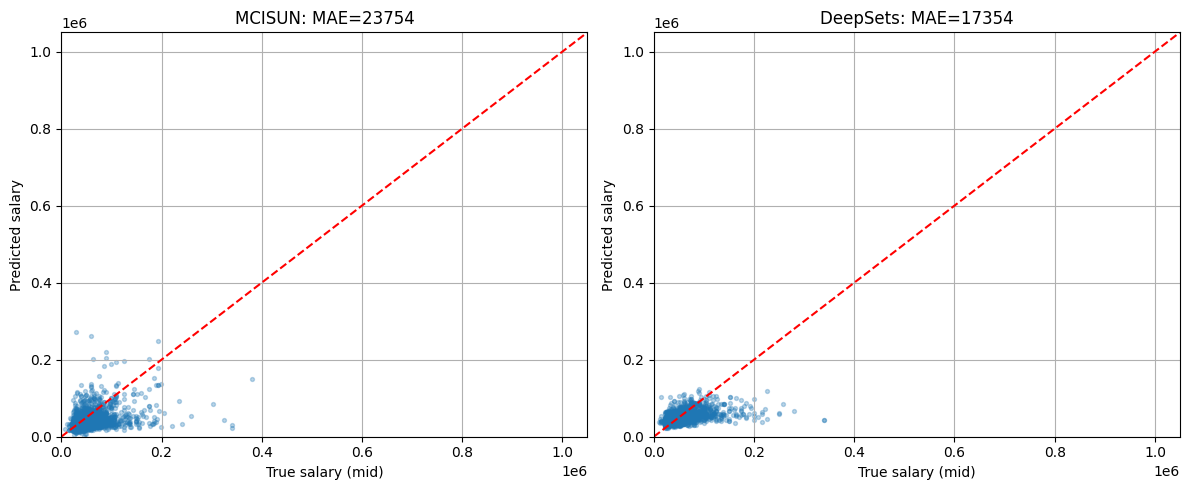

In [ ]:
plt.figure(figsize=(12, 5))
for i, (eval_res, name) in enumerate([(eval_mci, "MCISUN"), (eval_ds, "DeepSets")]):
    plt.subplot(1, 2, i + 1)
    sample_indices = np.random.choice(len(eval_res["y_true"]), size=min(2000, len(eval_res["y_true"])), replace=False)
    plt.scatter(eval_res["y_true"][sample_indices, 1], eval_res["y_pred"][sample_indices, 1], s=8, alpha=0.3)

    max_val = max(eval_res["y_true"][:, 1].max(), eval_res["y_pred"][:, 1].max()) * 1.05
    plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal')
    plt.xlabel("True salary (mid)"); plt.ylabel("Predicted salary")
    plt.title(f"{name}: MAE={eval_res['mid']['MAE']:.0f}")
    plt.grid(True); plt.tight_layout(); plt.xlim(0, max_val); plt.ylim(0, max_val)
plt.show()

In [ ]:
g = pd.read_csv(DATA_PATH, sep=',')

In [ ]:
g["professionalSphereName"].value_counts().head(1)

,count
professionalSphereName,
Производство,17388


In [ ]:
train_df['industry'].value_counts()

,count
industry,
Производство,5458
Здравоохранение и социальное обеспечение,4946
"Образование, наука",4446
"Продажи, закупки, снабжение, торговля",4129
"ЖКХ, эксплуатация",3375
"Государственная служба, некоммерческие организации",2904
"Бухгалтерия, налоги, управленческий учет",2879
"Транспорт, автобизнес, логистика, склад, ВЭД",2563
Пищевая промышленность,2309


In [ ]:

from IPython.display import display
import pandas as pd
import numpy as np

test_df_reset = test_df.reset_index(drop=True)

def get_metrics_for_subset(data_subset, model_eval_results):
    indices = data_subset.index
    y_true_subset = model_eval_results['y_true'][indices]
    y_pred_subset = model_eval_results['y_pred'][indices]
    mae_point = np.mean(np.abs(y_true_subset[:, 1] - y_pred_subset[:, 1]))
    true_interval = y_true_subset[:, 2] - y_true_subset[:, 0]
    pred_interval = y_pred_subset[:, 2] - y_pred_subset[:, 0]
    mae_interval = np.mean(np.abs(true_interval - pred_interval))
    return mae_point, mae_interval

report_data = []
unique_industries = test_df_reset['industry'].unique()

for industry in unique_industries:
    industry_subset = test_df_reset[test_df_reset['industry'] == industry]
    if len(industry_subset) < 5:
        continue

    ds_mae_point, ds_mae_interval = get_metrics_for_subset(industry_subset, eval_ds)
    mci_mae_point, mci_mae_interval = get_metrics_for_subset(industry_subset, eval_mci)

    report_data.append({
        'Специальность': industry,
        'DeepSets (точечный)': ds_mae_point,
        'DeepSets (интервальный)': ds_mae_interval,
        'MCISUN (точечный)': mci_mae_point,
        'MCISUN (интервальный)': mci_mae_interval
    })


report_df_by_industry = pd.DataFrame(report_data)

industries_in_report = report_df_by_industry['Специальность'].unique()
reportable_df = test_df_reset[test_df_reset['industry'].isin(industries_in_report)]

ds_total_mae, ds_total_interval = get_metrics_for_subset(reportable_df, eval_ds)
mci_total_mae, mci_total_interval = get_metrics_for_subset(reportable_df, eval_mci)

total_row = pd.DataFrame([{
    'Специальность': 'Полная матрица (показанные)',
    'DeepSets (точечный)': ds_total_mae,
    'DeepSets (интервальный)': ds_total_interval,
    'MCISUN (точечный)': mci_total_mae,
    'MCISUN (интервальный)': mci_total_interval
}])

report_df_final = pd.concat([total_row, report_df_by_industry], ignore_index=True)


report_df_final = report_df_final.set_index('Специальность')
column_order = [
    'DeepSets (точечный)', 'DeepSets (интервальный)',
    'MCISUN (точечный)', 'MCISUN (интервальный)'
]
report_df_sorted = pd.concat([
    report_df_final.head(1),
    report_df_final.iloc[1:].sort_values(by='DeepSets (точечный)')
])

print("Таблица — Результаты экспериментов (Метрика: MAE в рублях)")
display(report_df_sorted.style.format("{:,.1f}"))

Таблица — Результаты экспериментов (Метрика: MAE в рублях)


,DeepSets (точечный),DeepSets (интервальный),MCISUN (точечный),MCISUN (интервальный)
Специальность,,,,
Полная матрица (показанные),"17,353.8","13,595.6","23,754.9","13,585.9"
Пищевая промышленность,"8,240.6","10,505.7","16,603.3","23,066.1"
"Работы, не требующие квалификации","10,005.1","7,171.9","12,547.5","7,432.4"
Юриспруденция,"11,419.6","8,879.4","19,261.3","8,057.4"
"Туризм, гостиницы, рестораны","12,043.9","8,907.2","16,133.0","8,928.3"
"Бухгалтерия, налоги, управленческий учет","12,596.6","10,434.9","19,484.2","8,726.3"
"Образование, наука","12,906.5","9,068.8","17,961.7","9,394.6"
"ЖКХ, эксплуатация","13,020.8","8,748.9","16,626.6","9,175.4"
"Искусство, культура и развлечения","13,062.2","9,834.1","17,360.4","9,365.5"
